## Importing packages

In [1]:
from dolfinx import fem, mesh, plot
from dolfinx.fem.petsc import LinearProblem
from configs import *
import pyvista
import utils
import numpy as np
import ufl
from mpi4py import MPI

## Create a mesh, elements and spaces


In [2]:
domain = mesh.create_rectangle(
    MPI.COMM_WORLD,
    [np.array([0, 0]), np.array([WIDTH, HEIGHT])],
    [Nx, Ny],
    dtype=np.float64,
)

# from dolfinx import io
# with io.XDMFFile(MPI.COMM_WORLD, "heart_mesh.xdmf", "r") as xdmf:
#    domain = xdmf.read_mesh(name="Grid")
#    # tags = xdmf.read_meshtags(domain, name="Grid")

element = ufl.FiniteElement("P", domain.ufl_cell(), degree=2)
W = fem.FunctionSpace(domain, ufl.MixedElement(element, element))  # P1 FEM space
V1, sub1 = W.sub(0).collapse()
V2, sub2 = W.sub(1).collapse()

# Define test functions
psi, phi = ufl.TestFunctions(W)

# Define trialfunctions
V_m, U_e = ufl.TrialFunctions(W)

# Define functions
v_ = fem.Function(W)
w, w_n = fem.Function(V1), fem.Function(V1)
V_m_n = fem.Function(V1)

x = ufl.SpatialCoordinate(domain)
d = domain.topology.dim

## Initial transmembrane potential

In [3]:
def impulse_location(x):
    return (x[0] < R) & (x[1] < R)

cells = fem.locate_dofs_geometrical(V1, impulse_location)
V_m_n.x.array[:] = V_REST
V_m_n.x.array[cells] = np.full_like(cells, V_0)

# Conductivities

In [4]:
a_l = ufl.as_vector(
    [
        x[1] / ufl.sqrt(x[0] ** 2 + x[1] ** 2 + 1),
        -x[0] / ufl.sqrt(x[0] ** 2 + x[1] ** 2 + 1),
    ],
)

a_n = ufl.as_vector(
    [
        x[0] / ufl.sqrt(x[0] ** 2 + x[1] ** 2 + 1),
        x[1] / ufl.sqrt(x[0] ** 2 + x[1] ** 2 + 1),
    ],
)

# Conductivities
M_i = (
    SIGMA_IT
    * ufl.Identity(d)
    # + (SIGMA_IL - SIGMA_IT) * ufl.outer(a_l, a_l)
    # + (SIGMA_IN - SIGMA_IT) * ufl.outer(a_n, a_n)
)
M_e = (
    SIGMA_ET
    * ufl.Identity(d)
    # + (SIGMA_EL - SIGMA_ET) * ufl.outer(a_l, a_l)
    # + (SIGMA_EN - SIGMA_ET) * ufl.outer(a_n, a_n)
)

## Defining ufl expressions and a problem

In [5]:
F = (V_m - V_m_n) / DT * phi * ufl.dx + ufl.inner(
    ufl.dot(M_i, ufl.grad(V_m + U_e)), ufl.grad(phi)
) * ufl.dx

F += (
    ufl.inner(ufl.dot(M_i + M_e, ufl.grad(U_e)), ufl.grad(psi)) * ufl.dx
    + ufl.inner(ufl.dot(M_i, ufl.grad(V_m)), ufl.grad(psi)) * ufl.dx
)

problem = LinearProblem(
    a=ufl.lhs(F),
    L=ufl.rhs(F),
    u=v_,
    petsc_options={
        #   "ksp_type": "gmres",
        #   "ksp_rtol": 1e-6,
        #   "ksp_atol": 1e-10,
        #   "ksp_max_it": 10,
        #   "pc_type": "lu",
    },
)

### Setting up the plotting environment

In [6]:
grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V1))
plotter = pyvista.Plotter(notebook=True, off_screen=False)
plotter.open_gif("V_m_time.gif", fps=int(1 / DT))

grid.point_data["V_m"] = V_m_n.x.array

plotter.add_mesh(
    grid,
    # scalars="V_m",
    show_edges=True,
    lighting=False,
    smooth_shading=True,
    clim=[-100, 50],
)

Actor (0x7fa9d37a0b80)
  Center:                     (0.5, 0.5, 0.0)
  Pickable:                   True
  Position:                   (0.0, 0.0, 0.0)
  Scale:                      (1.0, 1.0, 1.0)
  Visible:                    True
  X Bounds                    -6.732E-19, 1.000E+00
  Y Bounds                    -6.732E-19, 1.000E+00
  Z Bounds                    0.000E+00, 0.000E+00
  User matrix:                Set
  Has mapper:                 True

Property (0x7fa9d37a1060)
  Ambient:                     0.0
  Ambient color:               Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Anisotropy:                  0.0
  Color:                       Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Culling:                     "none"
  Diffuse:                     1.0
  Diffuse color:               Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Edge color:                  Color(name='black', hex='#000000ff', opacity=255)
  Edge opacity:                1.0
  In

## Full time-stepping:

In [7]:
# List of signal values for each time step
signal = []
t = 0.0

# Iterate through time
while t < T:
    # Appending the transmembrane potential value at some point to a list
    signal.append(utils.evaluate_function_at_point(V_m_n, domain, [0.6, 0.6, 0.0]))
    # solving for V_m_n
    V_m_n.x.array[:] = V_m_n.x.array[:] + DT * utils.CustomCellModel.I_ion(
        V_m_n.x.array, w.x.array
    )
    # solving for ionic variable
    w.x.array[:] = w.x.array[:] + DT * utils.CustomCellModel.f(V_m_n.x.array, w.x.array)
    # Solve linear problem
    problem.solve()
    # Normalize solution for U_e to zero mean
    v_.x.array[sub2] = v_.x.array[sub2] - np.mean(v_.x.array[sub2])
    # Update solution for V_m
    V_m_n.x.array[:] = v_.x.array[sub1]

    # Print time
    print("t = %.3f" % t)

    # Update plot
    plotter.clear()
    grid.point_data["V_m"] = V_m_n.x.array[:]
    plotter.add_mesh(
        grid,
        # scalars="V_m",
        show_edges=True,
        lighting=False,
        smooth_shading=True,
        clim=[-100, 100],
    )
    plotter.add_title("t = %.3f" % t, font_size=24)
    plotter.write_frame()
    t += DT

plotter.close()

t = 0.000
t = 0.125
t = 0.250
t = 0.375
t = 0.500
t = 0.625
t = 0.750
t = 0.875
t = 1.000
t = 1.125
t = 1.250
t = 1.375
t = 1.500
t = 1.625
t = 1.750
t = 1.875
t = 2.000
t = 2.125
t = 2.250
t = 2.375
t = 2.500
t = 2.625
t = 2.750
t = 2.875
t = 3.000
t = 3.125
t = 3.250
t = 3.375
t = 3.500
t = 3.625
t = 3.750
t = 3.875
t = 4.000
t = 4.125
t = 4.250
t = 4.375
t = 4.500
t = 4.625
t = 4.750
t = 4.875
t = 5.000
t = 5.125
t = 5.250
t = 5.375
t = 5.500
t = 5.625
t = 5.750
t = 5.875
t = 6.000
t = 6.125
t = 6.250
t = 6.375
t = 6.500
t = 6.625
t = 6.750
t = 6.875
t = 7.000
t = 7.125
t = 7.250
t = 7.375
t = 7.500
t = 7.625
t = 7.750
t = 7.875
t = 8.000
t = 8.125
t = 8.250
t = 8.375
t = 8.500
t = 8.625
t = 8.750
t = 8.875
t = 9.000
t = 9.125
t = 9.250
t = 9.375
t = 9.500
t = 9.625
t = 9.750
t = 9.875
t = 10.000
t = 10.125
t = 10.250
t = 10.375
t = 10.500
t = 10.625
t = 10.750
t = 10.875
t = 11.000
t = 11.125
t = 11.250
t = 11.375
t = 11.500
t = 11.625
t = 11.750
t = 11.875
t = 12.000
t = 12.125
t 

### Plotting time dependence of transmembrane potential at a particular point

Text(0.5, 1.0, 'Time dependence of transmembrane potential')

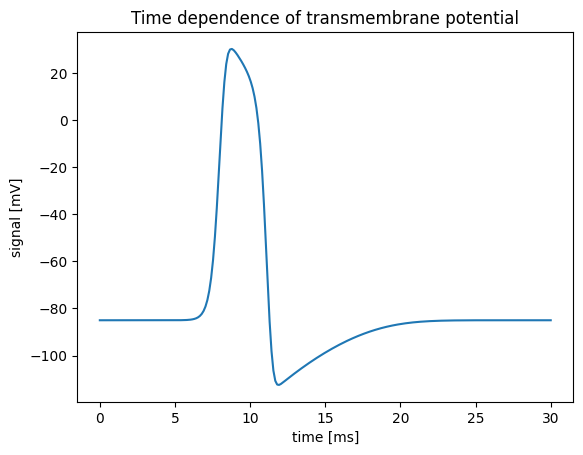

In [8]:
import matplotlib.pyplot as plt

time = np.linspace(0, T, NUM_STEPS)
plt.plot(time, signal)
plt.xlabel("time [ms]")
plt.ylabel("signal [mV]")
plt.title("Time dependence of transmembrane potential")

### Plotting a final plot of transmembrane potential

In [9]:
utils.plot_function(V_m_n, V1)

Widget(value='<iframe src="http://localhost:35441/index.html?ui=P_0x7fa9d37d6250_0&reconnect=auto" class="pyvi…